In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [58]:
# Veri setini yükleme ve işleme adımları
data = pd.read_csv(r"/content/drive/MyDrive/FaceDataSets/HardDataSet/data.csv")

# Resim boyutları
height, width = 224, 224

# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3))
for i in range(data.shape[0]):
    img = load_img(r"/content/drive/MyDrive/FaceDataSets/HardDataSet/{}/{}.jpg".format(data.loc[i, 'label'], data.loc[i, 'images_id']),
                   target_size=(height, width))
    img_array = img_to_array(img)
    # Piksel değerlerini [0, 1] aralığına normalleştirme
    img_array /= 255.0
    X[i] = img_array

# Etiketleri değiştirme
labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(lambda x: labels[x])

# One-hot encoding
y = to_categorical(y, len(labels))

# Veri setini train-test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


In [62]:
# DenseNet121 modelini yükleme
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(height, width, 3))

for layer in densenet.layers:
    layer.trainable = True
    layer._name = layer._name + '_densenet'  # Katman isimlerini değiştirme

# ResNet50 modelini yükleme
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

for layer in resnet.layers:
    layer.trainable = True
    layer._name = layer._name + '_resnet'  # Katman isimlerini değiştirme



# Transfer learning: DenseNet121 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x1 = Flatten()(densenet.output)
x1 = Dense(512, activation='relu')(x1)
x1 = Dropout(0.45)(x1)

# Transfer learning: ResNet50 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x2 = Flatten()(resnet.output)
x2 = Dense(512, activation='relu')(x2)
x2 = Dropout(0.45)(x2)

# DenseNet ve ResNet50 modellerinin çıktılarını birleştirme
concatenated = Concatenate()([x1, x2])

# Yeni sınıflandırma katmanını ekleme
output = Dense(len(labels), activation='softmax')(concatenated)

# Yeni modeli oluşturma
model = Model(inputs=[densenet.input, resnet.input], outputs=output)

# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [63]:
# Modelin eğitimi
epochs = 35
history = model.fit([X_train, X_train], y_train, epochs=epochs, validation_split=0.2)


Epoch 1/35
26/26 [==============================] - 121s 785ms/step - loss: 10.3709 - accuracy: 0.9005 - val_loss: 10207.4629 - val_accuracy: 0.5700
Epoch 2/35
26/26 [==============================] - 11s 415ms/step - loss: 0.5415 - accuracy: 0.9854 - val_loss: 373836.5625 - val_accuracy: 0.5411
Epoch 3/35
26/26 [==============================] - 11s 415ms/step - loss: 0.2785 - accuracy: 0.9951 - val_loss: 405.6187 - val_accuracy: 0.4589
Epoch 4/35
26/26 [==============================] - 11s 413ms/step - loss: 0.7027 - accuracy: 0.9854 - val_loss: 9355.6221 - val_accuracy: 0.5411
Epoch 5/35
26/26 [==============================] - 11s 414ms/step - loss: 0.2047 - accuracy: 0.9842 - val_loss: 219.2960 - val_accuracy: 0.8502
Epoch 6/35
26/26 [==============================] - 11s 413ms/step - loss: 0.0532 - accuracy: 0.9976 - val_loss: 755.1180 - val_accuracy: 0.4493
Epoch 7/35
26/26 [==============================] - 11s 413ms/step - loss: 0.1732 - accuracy: 0.9927 - val_loss: 125.4756 

Accuracy:
9/9 [==============================] - 4s 110ms/step


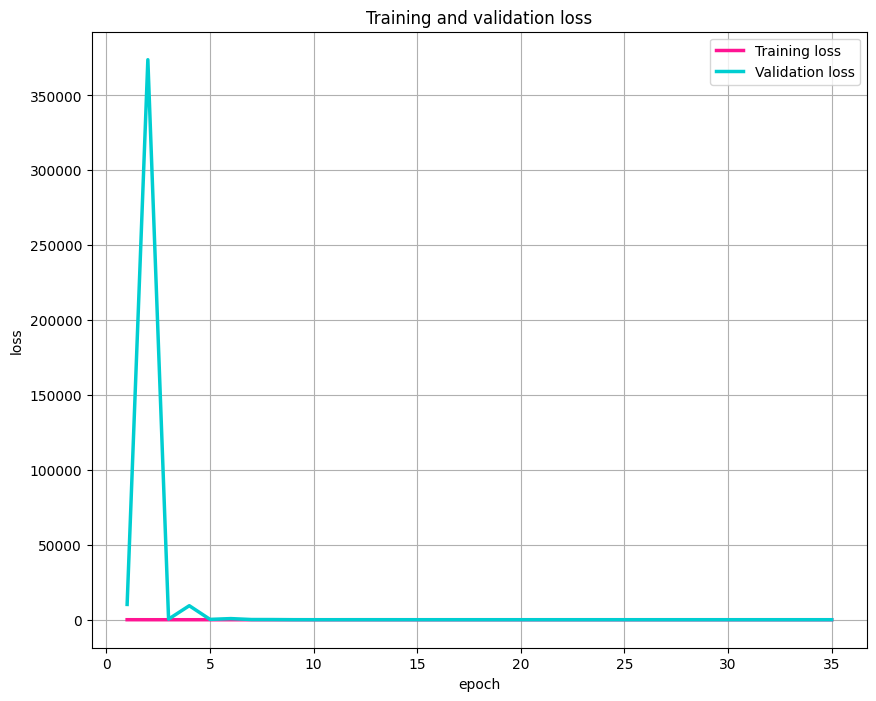

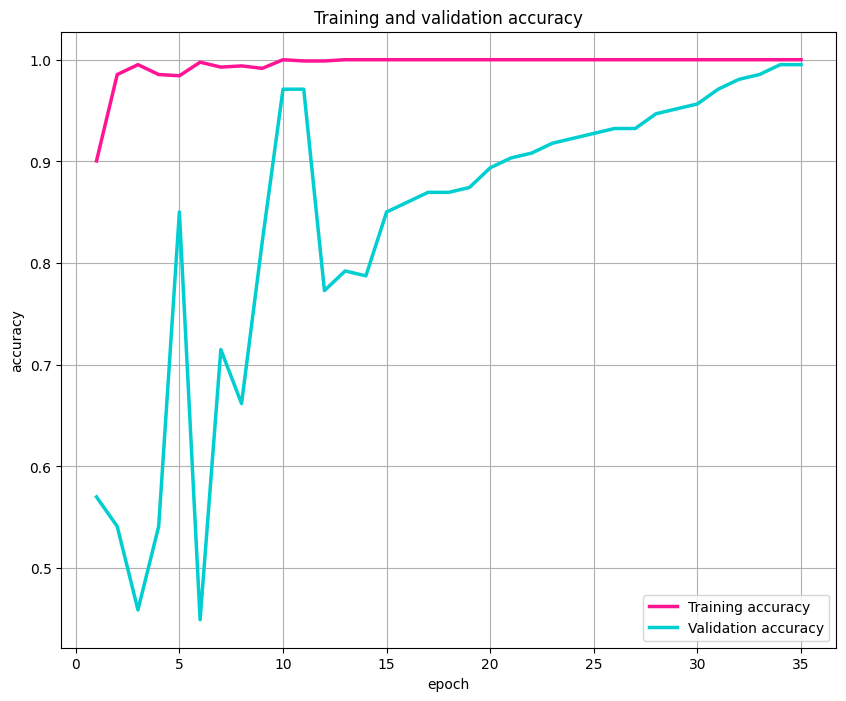

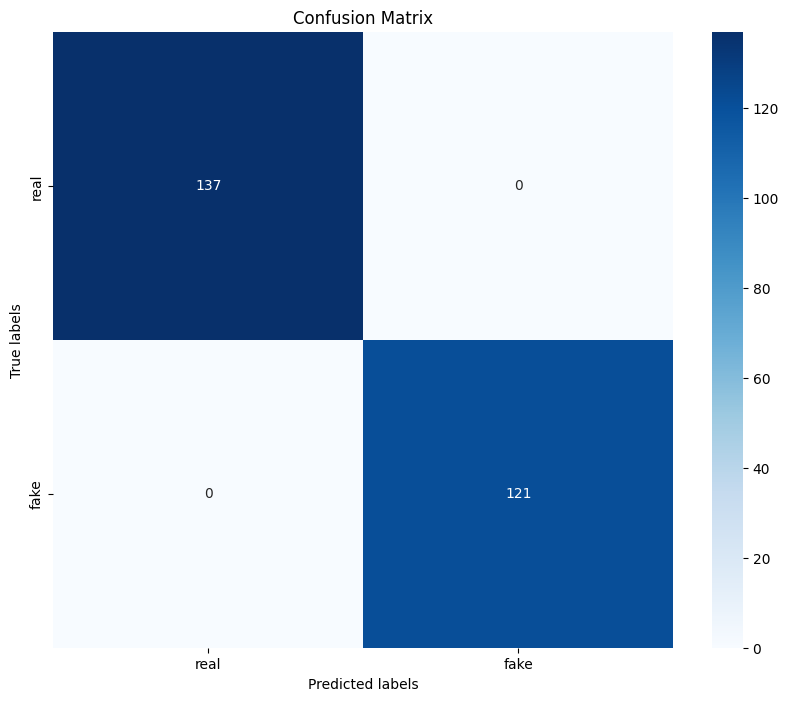

In [64]:
# Eğitim istatistiklerini görselleştirme
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, epochs + 1)

plt.figure(figsize=(10, 8))
sns.lineplot(y='loss', x='epoch', data=history_df, color='deeppink', linewidth=2.5, label="Training loss")
sns.lineplot(y='val_loss', x='epoch', data=history_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plt.grid()
plt.legend()
plt.title("Training and validation loss")

plt.figure(figsize=(10, 8))
sns.lineplot(y='accuracy', x='epoch', data=history_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sns.lineplot(y='val_accuracy', x='epoch', data=history_df, color='darkturquoise', linewidth=2.5, label="Validation accuracy")
plt.grid()
plt.legend()
plt.title("Training and validation accuracy")

# Test verisi üzerinde modelin performansını değerlendirme
print('Accuracy:')
_, accuracy = model.evaluate([X_test, X_test], y_test)

# Tahminleri al
y_pred = model.predict([X_test, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketler
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()